In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample

import optimusprimal.primal_dual as primal_dual
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

import optimusprimal as optpr
import ProxNest as prn
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

In [2]:
# Auxiliary functions

def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)



First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [3]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}

In [70]:
# Load Image
dim = 64
repo_dir = '/Users/tliaudat/Documents/postdoc/github/proxnest'
ground_truth = np.load(repo_dir + '/data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

x = ground_truth


In [71]:
# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)



In [72]:
# Simulate mock noisy observations y
y = phi.dir_op(ground_truth)
ISNR = 25
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n

x_init = np.abs(phi.adj_op(y))


## wavelet-based UQ

# Primal-dual alg


In [73]:
## Primal-dual FB Wavelet-based denoiser

reg_param = 2.5e-2

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param, psi)
h.beta = 1.0

# Real prox 
r = optpr.prox_operators.real_prox()
# f = None


In [74]:
# Run the alg

wvlt_best_estimate, wvlt_diagnostics = optpr.primal_dual.FBPD(
    x_init=x_init, options=options, g=g, f=None, h=h, r=r
)


2023-02-13 16:01:07,857 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-02-13 16:01:07,863 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.167741
2023-02-13 16:01:08,025 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.001638
2023-02-13 16:01:08,178 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.000902
2023-02-13 16:01:08,317 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.000394
2023-02-13 16:01:08,517 - Optimus Primal - INFO - [Primal Dual] 200 out of 5000 iterations, tol = 0.000165
2023-02-13 16:01:08,658 - Optimus Primal - INFO - [Primal Dual] 250 out of 5000 iterations, tol = 0.000102
2023-02-13 16:01:08,795 - Optimus Primal - INFO - [Primal Dual] 300 out of 5000 iterations, tol = 0.000083
2023-02-13 16:01:08,964 - Optimus Primal - INFO - [Primal Dual] 350 out of 5000 iterations, tol = 0.000065
2023-02-13 16:01:09,099 - Optimus Primal - INFO - [Primal Du

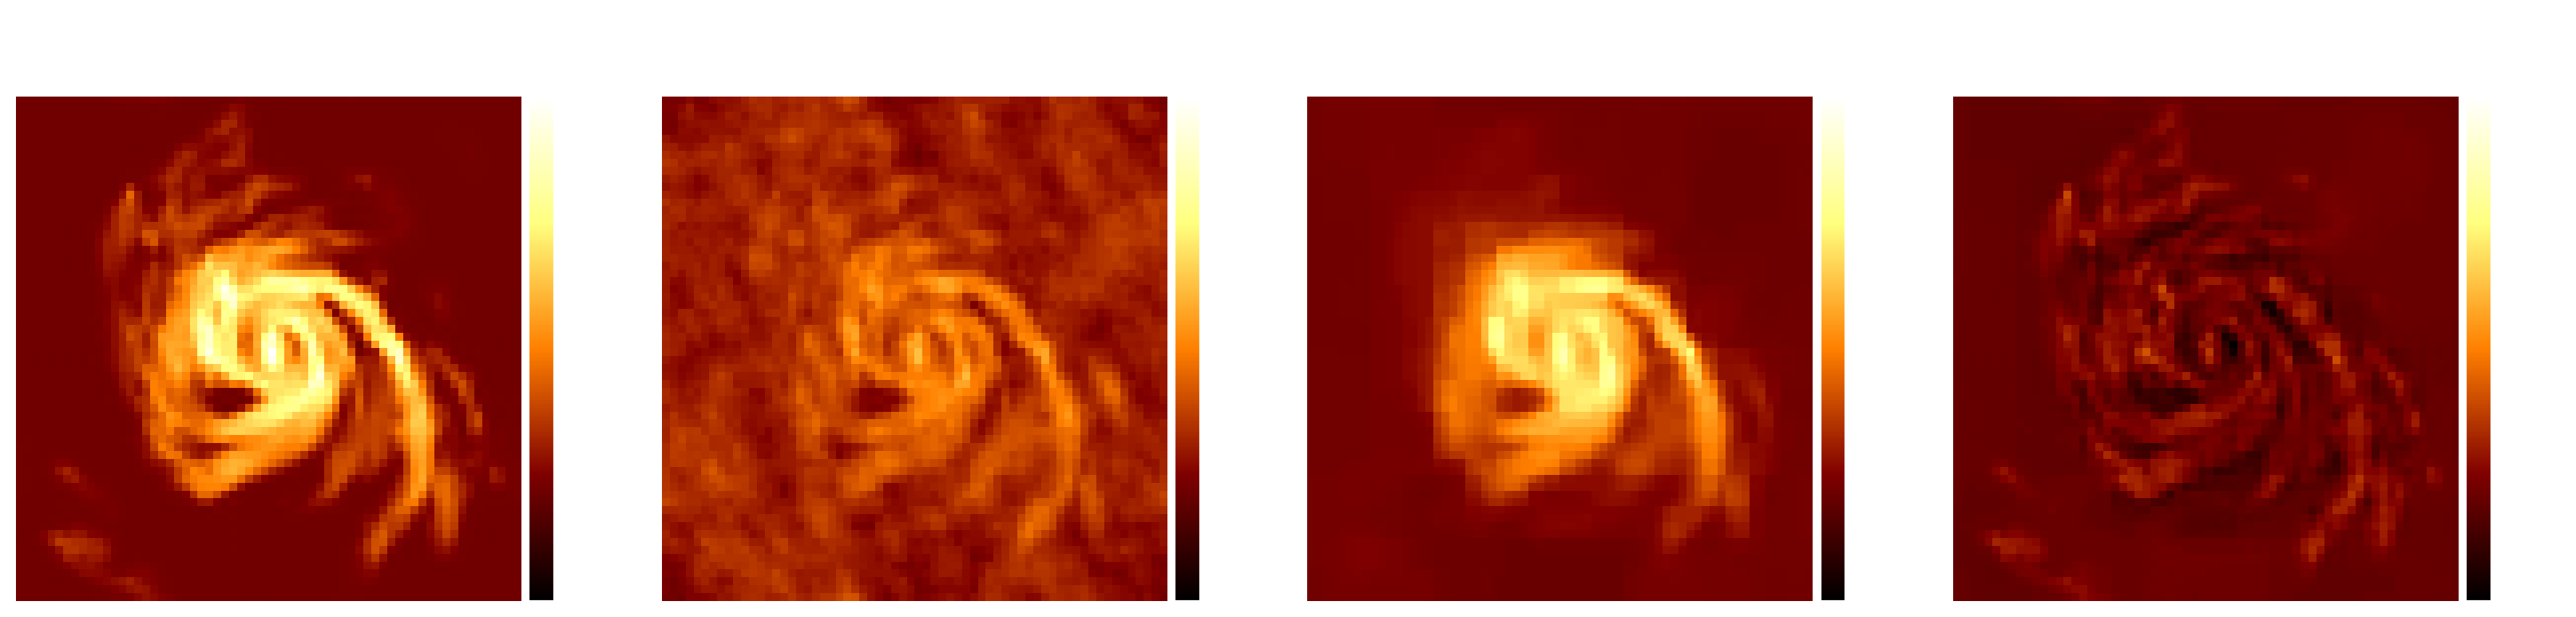

In [96]:
images = [x, x_init, np.abs(wvlt_best_estimate), x-np.abs(wvlt_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()

In [87]:
x_hat_np = np.abs(wvlt_best_estimate)


alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))


gamma_alpha = g.fun(x_hat_np) + h.fun(x_hat_np) + tau_alpha*np.sqrt(N) + N

loss_fun = lambda x_map : g.fun(x_map) +  h.fun(x_hat_np)


In [102]:
print(
    'f(x_map): ', g.fun(x_hat_np),
    ', g(x_map): ', h.fun(x_hat_np),
    'tau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    'N: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  8353.173281275842 , g(x_map):  26.086403571604624 tau_alpha*np.sqrt(N):  611.3943802972585 N:  4096
N:  4096
tau_alpha:  9.553037192144664
gamma_alpha:  13086.654065144705


In [105]:
error_p_2, error_m_2, mean_2 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=2,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_2 = error_p_2 - error_m_2

error_p_4, error_m_4, mean_4 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=4,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_4 = error_p_4 - error_m_4


error_p_8, error_m_8, mean_8 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=8,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_8 = error_p_8 - error_m_8


2023-02-13 16:53:32,657 - Optimus Primal - INFO - Calculating credible interval for (64, 64) superpxiels.
2023-02-13 16:53:32,663 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,665 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,666 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (0.0, 0.0) with sum 0.11143973181407175
2023-02-13 16:53:32,671 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,675 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,676 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (0.0, 0.0) with sum 0.12930928776227424
2023-02-13 16:53:32,680 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,683 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:53:32,684 - Op

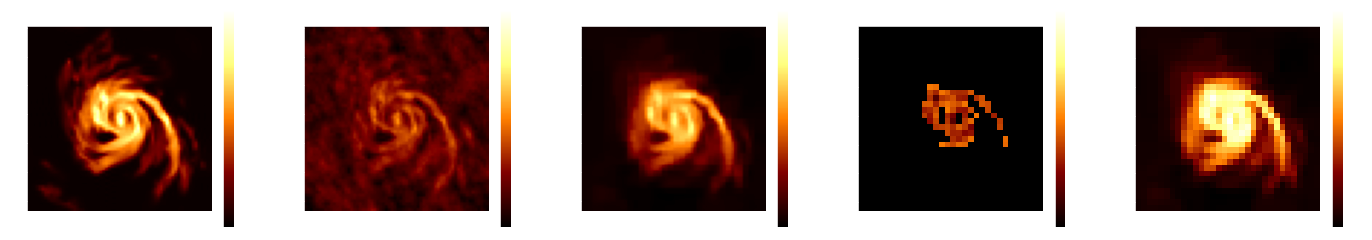

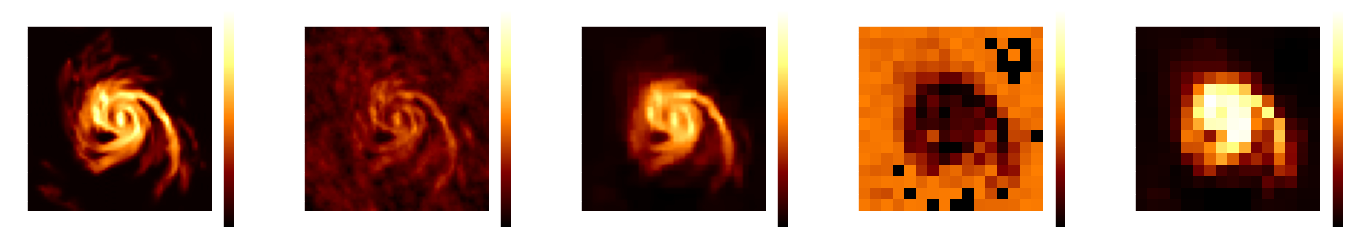

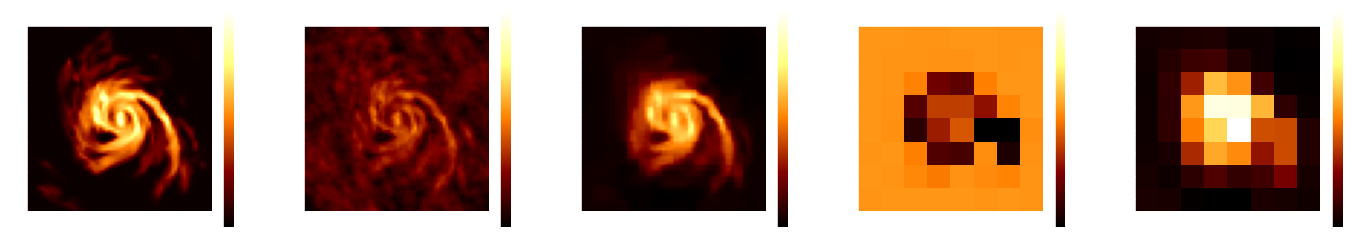

In [106]:
vmin = np.min((np.min((x, x_init, x_hat_np)), np.min(error_length_2), np.min(error_length_4), np.min(error_length_8)))
vmax = np.max((np.max((x, x_init, x_hat_np)), np.max(error_length_2), np.max(error_length_4), np.max(error_length_8)))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_2, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_2, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_wavelet-reg_superpix_2_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_4, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_4, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_wavelet-reg_superpix_4_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_8, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_8, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_wavelet-reg_superpix_8_range_05_-05.pdf')
plt.show()

In [92]:
error_length_4

array([[1.03384586, 1.03360319, 1.03358265, 1.03361971, 1.03350341,
        1.03366697, 1.03197335, 1.03293747, 1.03373659, 1.03333686,
        1.03487124, 1.03381548, 1.03311536, 1.03332505, 1.03369372,
        1.0364757 ],
       [1.0355404 , 1.03640185, 1.03570759, 1.03432317, 1.03419691,
        1.03621847, 1.0376386 , 1.03240103, 1.03354979, 1.03480238,
        1.03395592, 1.03358024, 1.03533642, 1.03369517, 1.03415229,
        1.03377287],
       [1.0338538 , 1.03482737, 1.03462286, 1.03351566, 1.03328988,
        1.0337411 , 1.03366117, 1.0310604 , 1.03222785, 1.03347408,
        1.03381628, 1.03445335, 1.03346403, 1.03391729, 1.03354608,
        1.03577814],
       [1.0342094 , 1.03666475, 1.03316606, 1.03583429, 1.03091876,
        1.03444105, 1.03399166, 1.03400307, 1.03099214, 1.03492197,
        1.03356089, 1.03580694, 1.03323925, 1.03353879, 1.03348216,
        1.03822335],
       [1.03359266, 1.03349734, 1.03186543, 1.03838225, 1.03456125,
        1.03596909, 1.00662601, 

### Compute the MAP


In [8]:
reg_param_FB = 5e-2

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param_FB, psi)
h.beta = 1.0

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None


In [9]:
# Run the alg

# Run the alg
alpha = 2 / (g.beta + 2)
wvlt_FB_best_estimate, wvlt_FB_diagnostics = optpr.forward_backward.FB(
    x_init=x_init, options=options, g=g, f=f, h=h, alpha=alpha, tau=1
)

wvlt_FB_best_estimate = np.abs(wvlt_FB_best_estimate)



2023-02-13 15:53:25,403 - Optimus Primal - INFO - Running Base Forward Backward
2023-02-13 15:53:25,497 - Optimus Primal - INFO - [Forward Backward] 0 out of 5000 iterations, tol = 0.571888
2023-02-13 15:53:25,638 - Optimus Primal - INFO - [Forward Backward] converged in 42 iterations


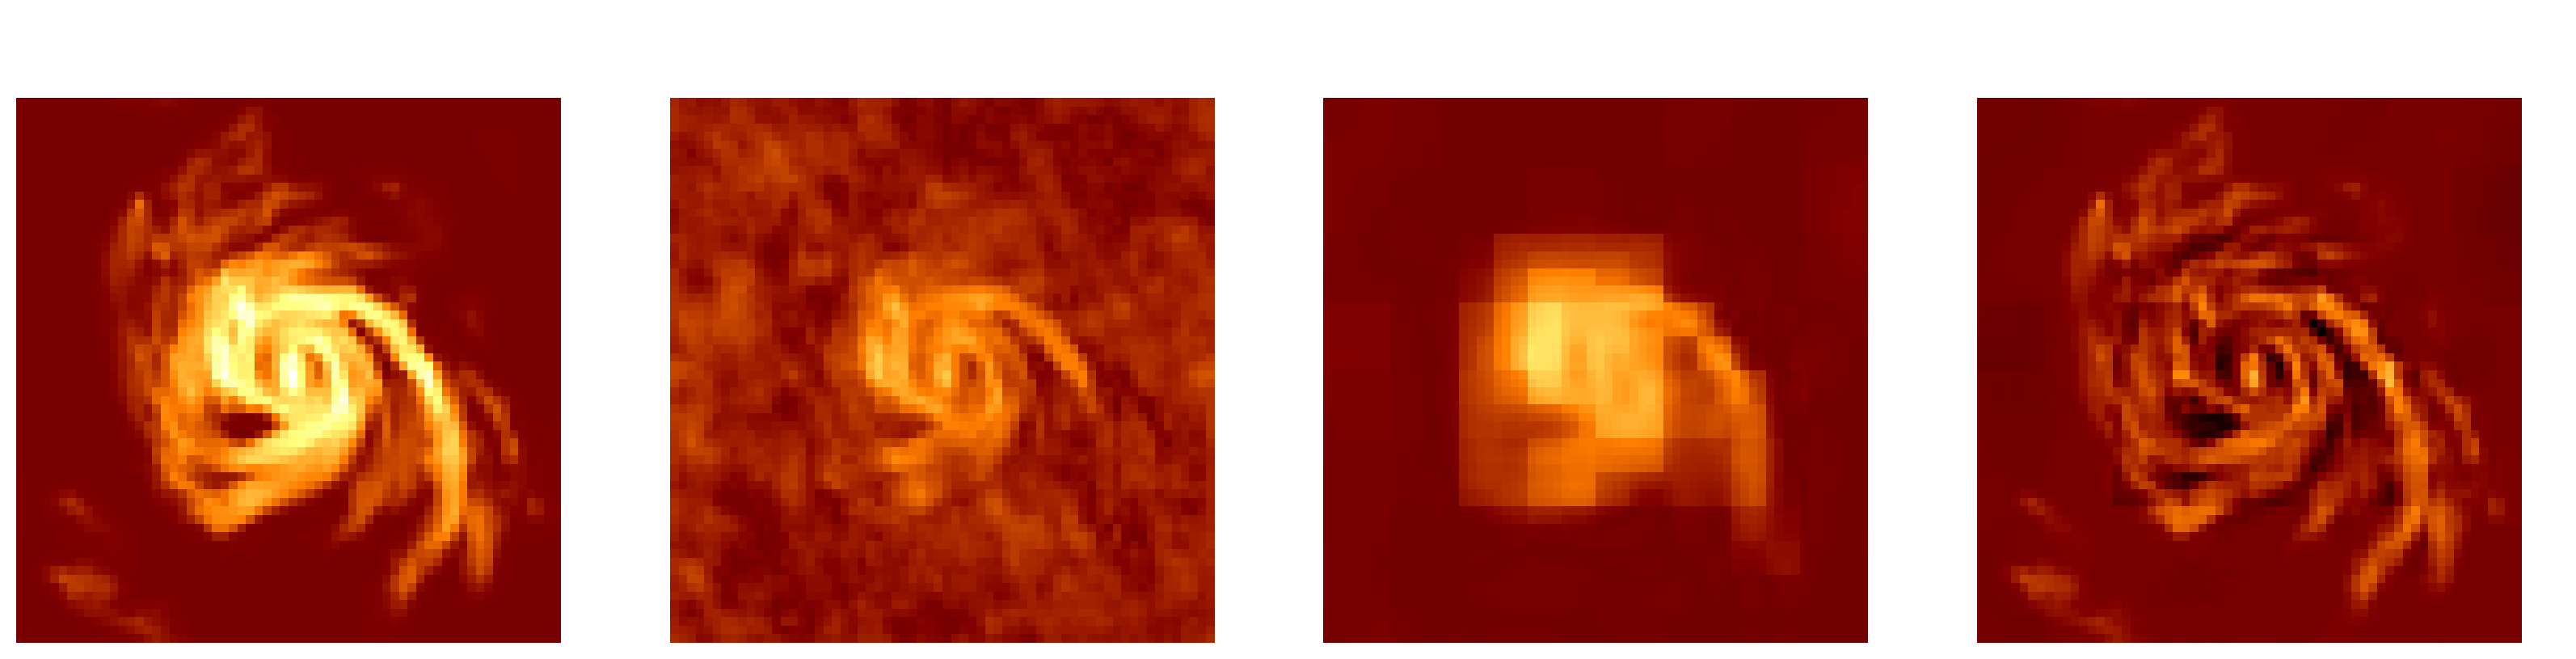

In [10]:
images = [x, x_init, np.abs(wvlt_FB_best_estimate), x-np.abs(wvlt_FB_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


<ipython-input-116-4f0fd10070e4>:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(ground_truth, images[i]),
/Users/tliaudat/miniconda3/envs/convex_uq/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


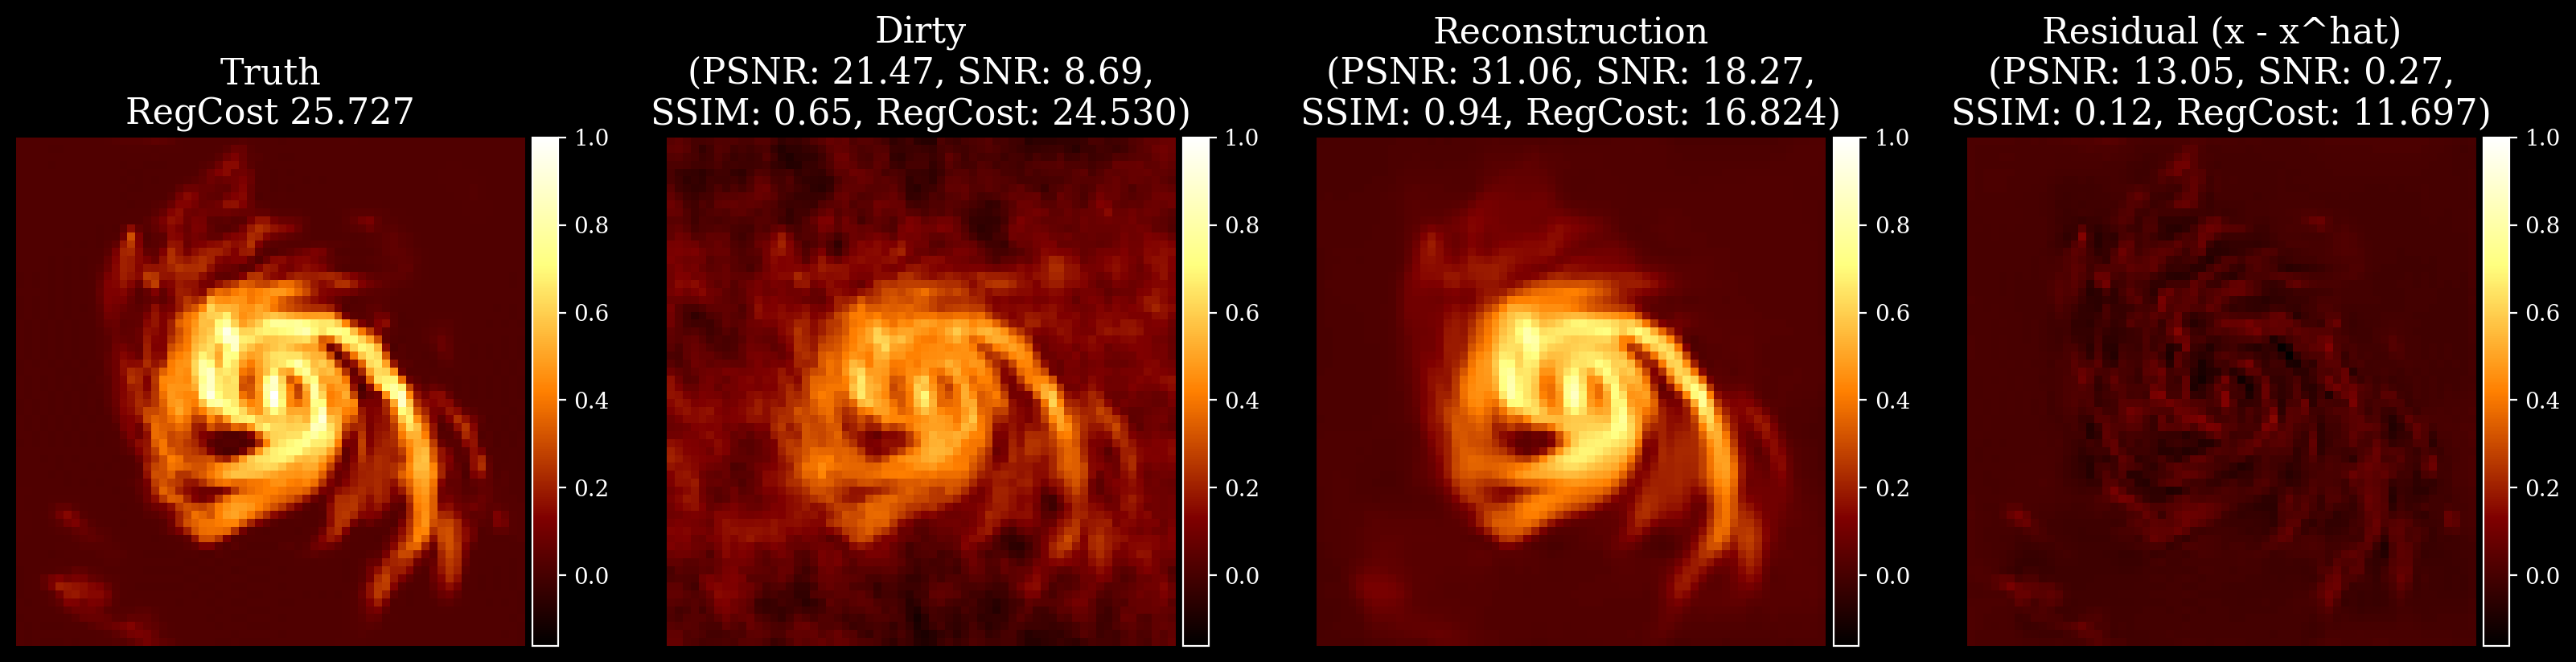

In [116]:
x_hat_np = x_hat.detach().cpu().squeeze().numpy()

images = [x, x_init, x_hat_np, x-np.abs(x_hat_np)]
images_torch = [x_torch, x_init_torch, x_hat, x_torch-x_hat]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(mu * images_torch[i])[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(ground_truth, images[i]),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i]),
            model.cost(mu * images_torch[i])[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()

### Compute HPD region

In [76]:
alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

prior_fun = lambda model, x_hat, mu, lambda_param : (lambda_param/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False))

# gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N

gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N


loss_fun = lambda x_map : g.fun(x_map) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy()


In [123]:

print(
    'f(x_map): ', g.fun(x_hat_np),
    ', g(x_map): ', (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy(),
    'tau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    'N: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  2765.181858574208 , g(x_map):  2.5236671447753904 tau_alpha*np.sqrt(N):  2445.577521189034 N:  65536
N:  65536
tau_alpha:  9.553037192144664
gamma_alpha:  170512.44416505328


In [78]:
error_p_20, error_m_20, mean_20 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=20,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_20 = error_p_20 - error_m_20

2023-02-13 14:01:48,707 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-13 14:01:59,077 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.18708070693537593, 0.1937292842194438) with sum 0.22462681
2023-02-13 14:02:09,282 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.18943569576367736, 0.19136962154880166) with sum 0.38651627
2023-02-13 14:02:19,289 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.18530870880931616, 0.19554684264585376) with sum 0.5431942
2023-02-13 14:02:30,610 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.1886284693609923, 0.1921971240080893) with sum 0.593326
2023-02-13 14:02:45,428 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.190088257426396, 0.1900817323476076) with sum 2.6574893
2023-02-13 14:03:02,813 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.15816169860772789, 0.22087574703618884

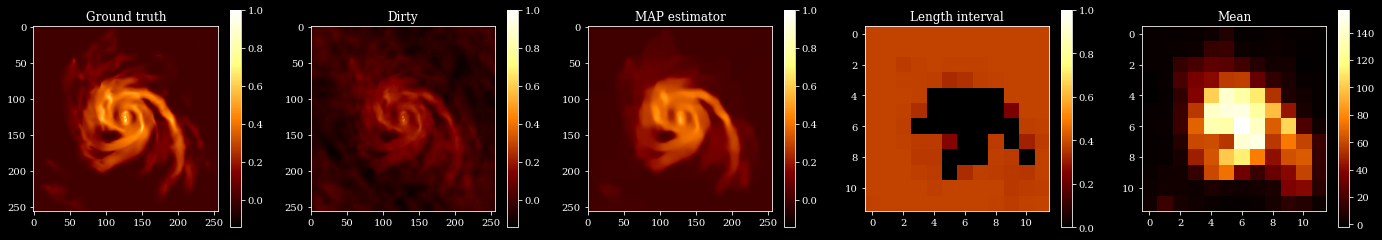

In [89]:
vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_256_CCR-reg_superpix_20.pdf')
plt.show()

In [65]:

#  x_sol, region_size, function, bound, iters, tol, bottom, top
# error_p_2, error_m_2, mean_2 = optpr.map_uncertainty.create_local_credible_interval(
#     x_sol=x_hat_np,
#     region_size=2,
#     function=loss_fun,
#     bound=gamma_alpha,
#     iters=200,
#     tol=1e-4,
#     bottom=-1.,
#     top=2.,
# )
# error_length_2 = error_p_2 - error_m_2

error_p_4, error_m_4, mean_4 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=4,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_4 = error_p_4 - error_m_4


error_p_8, error_m_8, mean_8 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=8,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_8 = error_p_8 - error_m_8

# np.sqrt(np.sum(x_hat_np**2)/x_hat_np.size)


2023-02-13 13:43:56,420 - Optimus Primal - INFO - Calculating credible interval for (64, 64) superpxiels.
2023-02-13 13:43:56,898 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.36372319608926773, 0.3536841347813606) with sum -0.029400336
2023-02-13 13:43:57,266 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.35999583452939987, 0.35730331391096115) with sum -0.04745282
2023-02-13 13:43:57,629 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.369014672935009, 0.3483160212635994) with sum -0.08605468
2023-02-13 13:43:58,006 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.37268760800361633, 0.3448195308446884) with sum -0.09325599
2023-02-13 13:43:58,346 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.3668326362967491, 0.3503881171345711) with sum -0.071997985
2023-02-13 13:43:58,762 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.3602312207221985, 0.3571401014

In [64]:
# error_length_4_it_200 = np.copy(error_length_4)
# mean_4_it_200 = np.copy(mean_4)

In [118]:
x.shape

(64, 64)

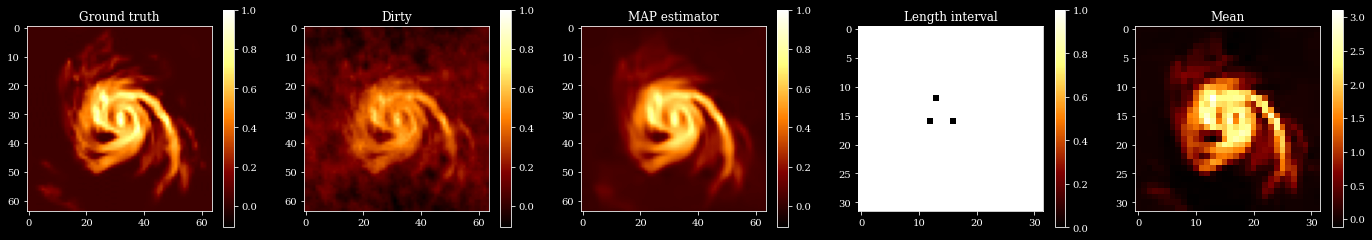

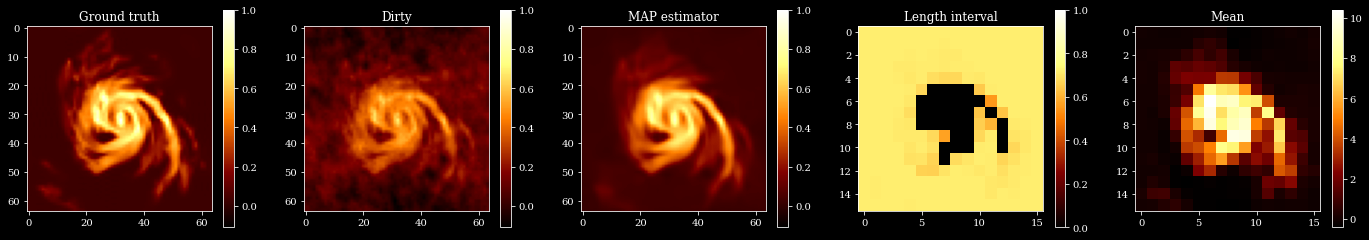

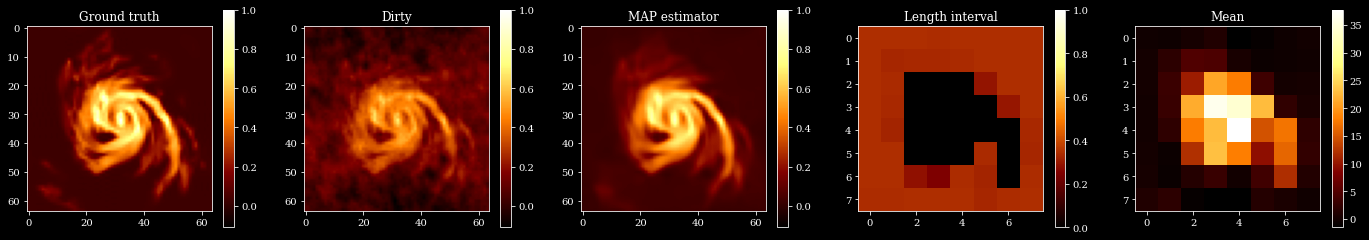

In [117]:

vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_2, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_2, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_2.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_4, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_4, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_4.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_8, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_8, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_8.pdf')
plt.show()

